# TEP-NET Model Evaluation & Comparison

This notebook evaluates and compares different TEP-NET model variants (e.g., Baseline, Symmetric Attention, Interaction Map) on the Test set.

**Key Evaluations:**
1. **Overall Performance:** ROC AUC, Precision, Recall, F1-Score.
2. **Generalization (TPP):** Performance broken down by TCR-Peptide Pairing categories (TPP1-TPP4).
3. **Visualizations:** ROC Curves and Metric Comparison Plots.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ===========================
#        CONFIGURATION
# ===========================

SAVE_FIGURES = False
FIGURES_TAG = 'Version 1 and 2' # e.g. 'SGD Optimizer', 'Version 1', 'Best Models'
FIGURES_TAG_APPENDIX = '_test' # e.g. '_adam', '_v2', 'best_models'

DATA_PATH = './dataset/processed/'
MODEL_PATH = './tmp/'
FIG_OUTPUT_PREFIX = './output/'

MODELS_TO_EVALUATE = {
    'v0 Baseline': 'TEPNETenh_model_v0_64_pca_baseline.keras',
    'v1 SymCA SGD': 'TEPNETenh_model_v1_64_pca_sgd.keras',
    'v1 SymCA ADAM': 'TEPNETenh_model_v1_64_pca_adam.keras',
    'v2 SymCA+TraBl SGD': 'TEPNETenh_model_v2_64_pca_sgd.keras',
    'v2 SymCA+TraBl ADAM': 'TEPNETenh_model_v2_64_pca_adam.keras',
    # 'v3 SymCA+IntM': 'TEPNETenh_model_v3_64_pca_sgd.keras',
    # 'v3 SymCA+IntM': 'TEPNETenh_model_v3_64_pca_adam.keras',
    # 'v4 SymCA+ResNH': 'TEPNETenh_model_v4_64_pca_sgd.keras',
    # 'v4 SymCA+ResNH': 'TEPNETenh_model_v4_64_pca_adam.keras',
    # 'v5 SCA+IM+RNH': 'TEPNETenh_model_v5_64_pca_sgd.keras',
    # 'v5 SCA+IM+RNH': 'TEPNETenh_model_v5_64_pca_adam.keras',
    # 'v6 SCA+TB+IM': 'TEPNETenh_model_v6_64_pca_sgd.keras',
    # 'v6 SCA+TB+IM': 'TEPNETenh_model_v6_64_pca_adam.keras',
    # 'v7 SCA+TB+RNH': 'TEPNETenh_model_v7_64_pca_sgd.keras',
    # 'v7 SCA+TB+RNH': 'TEPNETenh_model_v7_64_pca_adam.keras',
    # 'v8 Full Arch': 'TEPNETenh_model_v8_64_pca_sgd.keras',
    # 'v8 Full Arch': 'TEPNETenh_model_v8_64_pca_adam.keras',
}

EMBEDDING_DIM = 64
EMBEDDING_TYPE = 'pca'
CHUNK_SIZE = 5000
FEATURE_COLUMNS = [
    'TCR_KF7', 'TCR_KF1', 'TCR_hydrophobicity', 'TCR_aromaticity', 
    'TCR_isoelectric_point', 'TCR_instability_index', 
    'epitope_KF7', 'epitope_KF1','epitope_hydrophobicity', 'epitope_aromaticity',
    'epitope_isoelectric_point', 'epitope_instability_index'
]

if SAVE_FIGURES:
    os.makedirs(FIG_OUTPUT_PREFIX, exist_ok=True)

In [2]:
# ===========================
#      CUSTOM LAYERS
# ===========================
# We must define these to load the models successfully

@tf.keras.utils.register_keras_serializable()
class PiecewiseLinearEncoding(Layer):
    def __init__(self, bins, **kwargs):
        super(PiecewiseLinearEncoding, self).__init__(**kwargs)
        self.bins = tf.convert_to_tensor(bins, dtype=tf.float32)

    def call(self, inputs):
        inputs_expanded = tf.expand_dims(inputs, axis=-1)
        bin_widths = self.bins[1:] - self.bins[:-1]
        bin_edges = (inputs_expanded - self.bins[:-1]) / bin_widths
        bin_edges = tf.clip_by_value(bin_edges, 0.0, 1.0)
        return bin_edges

    def get_config(self):
        config = super().get_config()
        config.update({"bins": self.bins.numpy().tolist()})
        return config

@tf.keras.utils.register_keras_serializable()
class PeriodicEmbeddings(Layer):
    def __init__(self, num_frequencies=16, **kwargs):
        super(PeriodicEmbeddings, self).__init__(**kwargs)
        self.num_frequencies = num_frequencies
        self.freqs = tf.Variable(
            initial_value=tf.random.uniform(shape=(num_frequencies,), minval=0.1, maxval=1.0),
            trainable=True
        )

    def call(self, inputs):
        inputs_expanded = tf.expand_dims(inputs, axis=-1)
        periodic_features = tf.concat([
            tf.sin(2 * np.pi * inputs_expanded * self.freqs),
            tf.cos(2 * np.pi * inputs_expanded * self.freqs)
        ], axis=-1)
        return periodic_features

    def get_config(self):
        config = super().get_config()
        config.update({"num_frequencies": self.num_frequencies})
        return config

@tf.keras.utils.register_keras_serializable()
class ExpandDimsLayer(Layer):
    def __init__(self, axis=1, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})
        return config

In [3]:
# ===========================
#      DATA LOADING
# ===========================

def load_full_data_to_ram(h5_path):
    print(f"Loading {h5_path}...")
    with h5py.File(h5_path, 'r') as f:
        tcr = f['TCR'][:]
        epi = f['epitope'][:]
        
        meta_data = {}
        for key in f['meta'].keys():
            meta_data[key] = f[f'meta/{key}'][:] # Load as bytes
            
    df = pd.DataFrame(meta_data)
    
    # Convert bytes to strings for sequence matching
    for col in ['TCR_raw', 'epitope_raw']:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else str(x))

    # Preprocess Inputs
    X_feat = df[FEATURE_COLUMNS].values.astype(np.float32)
    y = df['binding'].values.astype(np.float32)
    X_tcr = tcr.astype(np.float32)
    X_epi = epi.astype(np.float32)
    
    return X_tcr, X_epi, X_feat, y, df

# 1. Load Training Data (Only Metadata needed for TPP logic)
# We don't need heavy embeddings for training data here, just the sequences
def load_train_sequences_only(h5_path):
    print(f"Loading Training Metadata from {h5_path}...")
    with h5py.File(h5_path, 'r') as f:
        meta_data = {}
        for key in ['TCR_raw', 'epitope_raw']:
            meta_data[key] = f[f'meta/{key}'][:] 
    
    df = pd.DataFrame(meta_data)
    for col in df.columns:
        df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else str(x))
    return df

train_h5 = os.path.join(DATA_PATH, f'train_ProtBERT_{EMBEDDING_DIM}_{EMBEDDING_TYPE}.h5')
test_h5 = os.path.join(DATA_PATH, f'test_ProtBERT_{EMBEDDING_DIM}_{EMBEDDING_TYPE}.h5')

df_train_meta = load_train_sequences_only(train_h5)
X_test_tcr, X_test_epi, X_test_feat, y_test, df_test = load_full_data_to_ram(test_h5)

Loading Training Metadata from ./dataset/processed/train_ProtBERT_64_pca.h5...
Loading ./dataset/processed/test_ProtBERT_64_pca.h5...


In [4]:
# ===========================
#      TPP LOGIC
# ===========================

def get_tpp_indices(df_train, df_test):
    print("Calculating TPP Indices...")
    train_tcr_set = set(df_train['TCR_raw'])
    train_epi_set = set(df_train['epitope_raw'])
    
    tpp_indices = {'TPP1': [], 'TPP2': [], 'TPP3': [], 'TPP4': []}
    
    for i, row in df_test.iterrows():
        tcr_known = row['TCR_raw'] in train_tcr_set
        epi_known = row['epitope_raw'] in train_epi_set
        
        if tcr_known and epi_known:
            tpp_indices['TPP1'].append(i)
        elif not tcr_known and epi_known:
            tpp_indices['TPP2'].append(i)
        elif not tcr_known and not epi_known:
            tpp_indices['TPP3'].append(i)
        elif tcr_known and not epi_known:
            tpp_indices['TPP4'].append(i)
            
    for k, v in tpp_indices.items():
        print(f"{k}: {len(v)} samples")
        
    return tpp_indices

tpp_indices = get_tpp_indices(df_train_meta, df_test)

Calculating TPP Indices...
TPP1: 44993 samples
TPP2: 43754 samples
TPP3: 27802 samples
TPP4: 11142 samples


In [5]:
# ===========================
#      EVALUATION LOOP
# ===========================

results_table = []
roc_data = {}

for model_name, model_file in MODELS_TO_EVALUATE.items():
    full_path = os.path.join(MODEL_PATH, model_file)
    if not os.path.exists(full_path):
        print(f"Skipping {model_name}: File not found ({full_path})")
        continue
        
    print(f"\nEvaluating {model_name}...")
    
    # Load Model with Custom Objects
    model = load_model(full_path, custom_objects={
        'PiecewiseLinearEncoding': PiecewiseLinearEncoding,
        'PeriodicEmbeddings': PeriodicEmbeddings,
        'ExpandDimsLayer': ExpandDimsLayer
    })
    
    # 1. Global Predictions
    y_pred_prob = model.predict(
        {"TCR_Input": X_test_tcr, "Epitope_Input": X_test_epi, "Physicochemical_Features": X_test_feat}, 
        verbose=0
    ).flatten()
    
    y_pred_class = (y_pred_prob > 0.5).astype(int)
    
    # Global Metrics
    roc = roc_auc_score(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred_class)
    prec = precision_score(y_test, y_pred_class)
    rec = recall_score(y_test, y_pred_class)
    
    # Store ROC Data for plotting
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_data[model_name] = (fpr, tpr, roc)
    
    model_results = {
        'Model': model_name,
        'Global ROC': roc,
        'Global F1': f1,
        'Global Precision': prec,
        'Global Recall': rec
    }
    
    # 2. TPP Evaluations
    for tpp, indices in tpp_indices.items():
        if len(indices) == 0:
            model_results[f'{tpp} F1'] = 0
            continue
            
        sub_y_true = y_test[indices]
        sub_y_pred = y_pred_class[indices]
        sub_f1 = f1_score(sub_y_true, sub_y_pred, zero_division=0)
        model_results[f'{tpp} F1'] = sub_f1
        
    results_table.append(model_results)

# Convert to DataFrame
df_results = pd.DataFrame(results_table)
display(df_results)


Evaluating v0 Baseline...


I0000 00:00:1766173586.147763 3721836 service.cc:148] XLA service 0x347fb2d40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766173586.148543 3721836 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-12-19 20:46:26.247002: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1766173586.559073 3721836 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Evaluating v1 SymCA SGD...

Evaluating v1 SymCA ADAM...

Evaluating v2 SymCA+TraBl SGD...

Evaluating v2 SymCA+TraBl ADAM...


,Model,Global ROC,Global F1,Global Precision,Global Recall,TPP1 F1,TPP2 F1,TPP3 F1,TPP4 F1
0,v0 Baseline,0.849442,0.599796,0.605585,0.594117,0.551284,0.474802,0.728782,0.873610
1,v1 SymCA SGD,0.885537,0.652064,0.579405,0.745560,0.621036,0.566739,0.751264,0.899209
2,v1 SymCA ADAM,0.737928,0.375656,0.267570,0.630251,0.344593,0.425306,0.454060,0.135374
3,v2 SymCA+TraBl SGD,0.868464,0.530030,0.388026,0.835965,0.443478,0.547787,0.663242,0.496241
4,v2 SymCA+TraBl ADAM,0.749506,0.406008,0.260569,0.918899,0.336452,0.606109,0.464899,0.105048


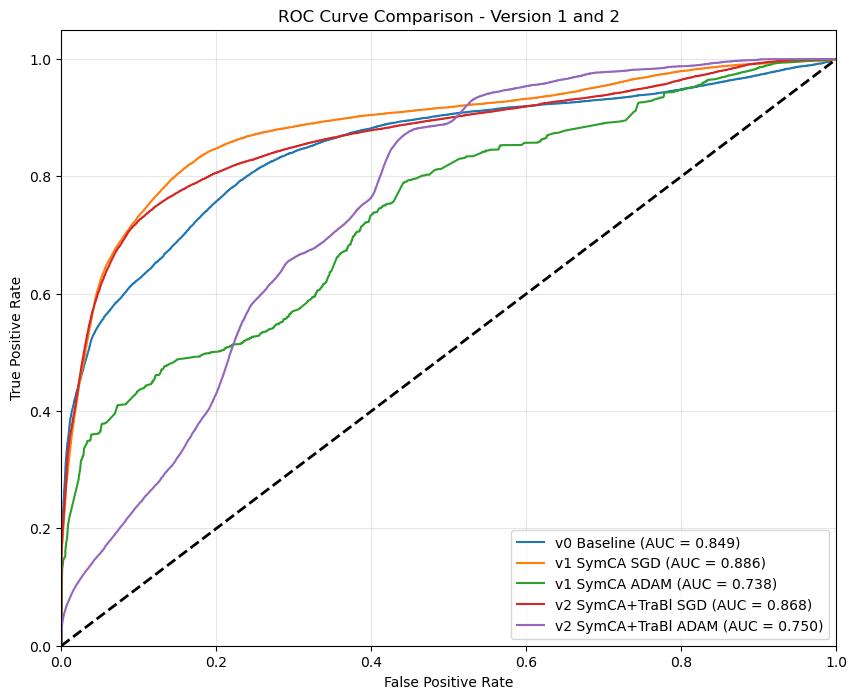

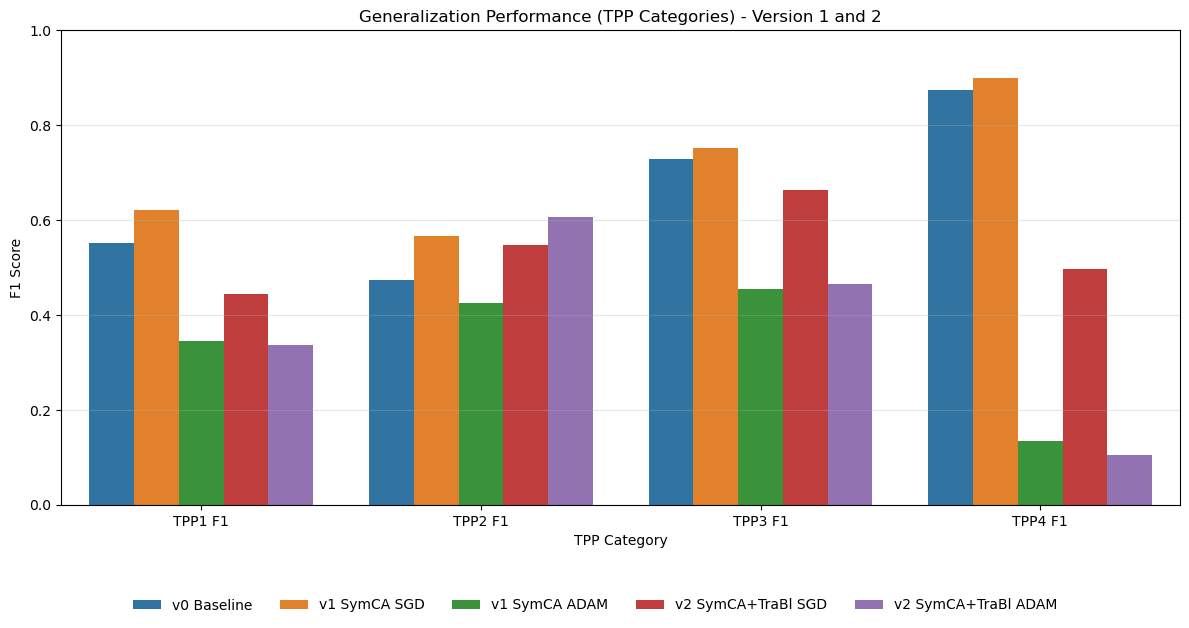

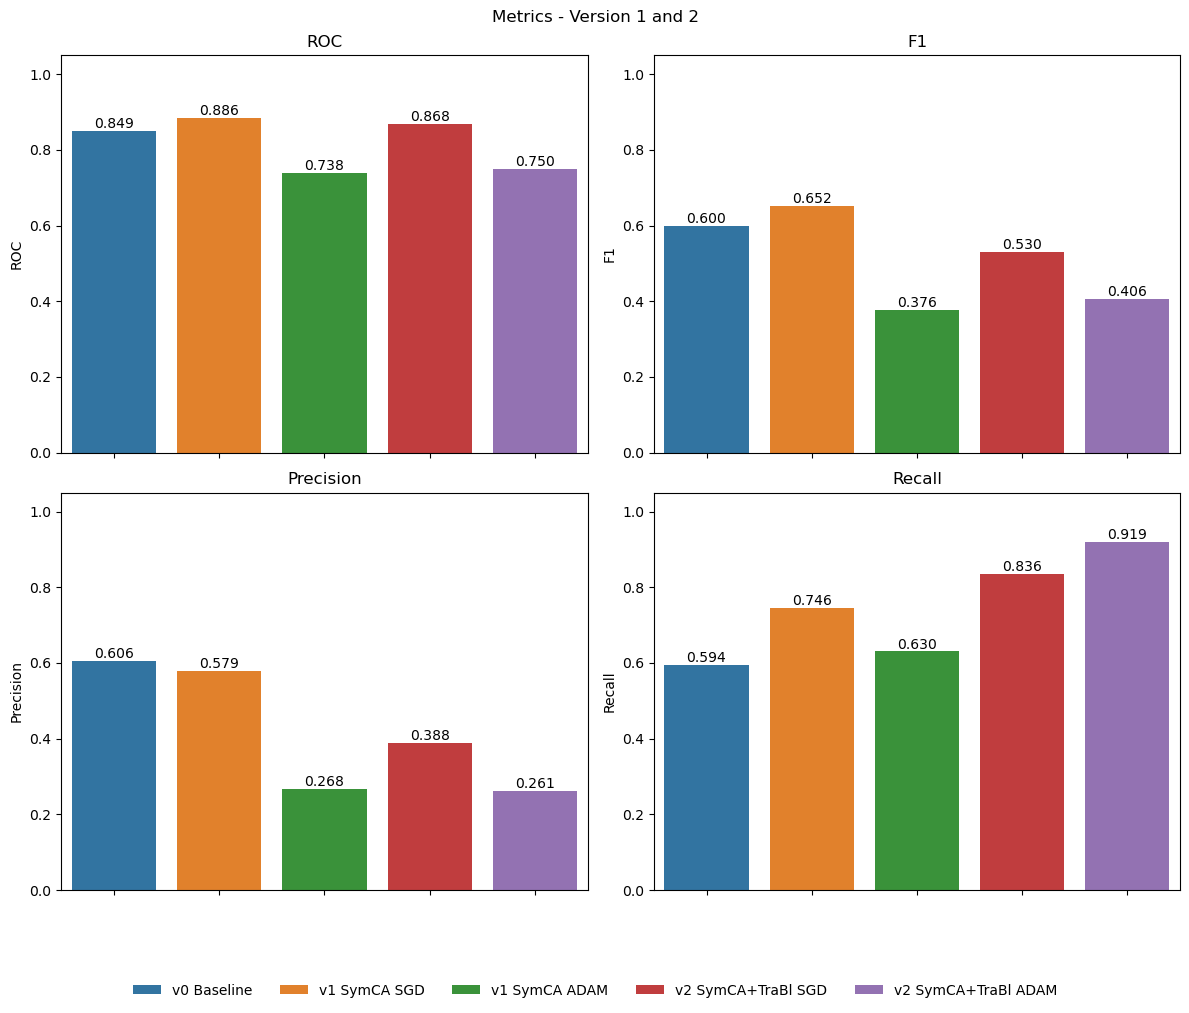

In [6]:
# ===========================
#      VISUALIZATION
# ===========================

# 1. ROC Curves
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr, auc_val) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_val:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"ROC Curve Comparison{'' if FIGURES_TAG == '' else f" - {FIGURES_TAG}"}")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

if SAVE_FIGURES:
    plt.figure().savefig(f'{FIG_OUTPUT_PREFIX}plot_roc_curves{FIGURES_TAG_APPENDIX}.png', dpi=96, bbox_inches='tight')

# 2. TPP Performance Plot
if not df_results.empty:
    tpp_cols = ['TPP1 F1', 'TPP2 F1', 'TPP3 F1', 'TPP4 F1']
    df_melt = df_results.melt(id_vars=['Model'], value_vars=tpp_cols, var_name='TPP Category', value_name='F1 Score')
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(data=df_melt, x='TPP Category', y='F1 Score', hue='Model', ax=ax)
    ax.set_title(f"Generalization Performance (TPP Categories){'' if FIGURES_TAG == '' else f" - {FIGURES_TAG}"}")
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', alpha=0.3)
    
    # Remove the default legend
    ax.get_legend().remove()
    
    # Create legend at the bottom
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(
        handles, 
        labels, 
        loc='lower center', 
        ncol=min(len(labels), 5), 
        bbox_to_anchor=(0.5, -0.05), 
        frameon=False
    )
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the legend
    plt.show()
    
    if SAVE_FIGURES:
        fig.savefig(f'{FIG_OUTPUT_PREFIX}plot_tpp_performance{FIGURES_TAG_APPENDIX}.png', dpi=96, bbox_inches='tight')

# 3. ROC, F1, Precision and Recall Metrics
if not df_results.empty:
    metrics = ['Global ROC', 'Global F1', 'Global Precision', 'Global Recall']

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    fig.suptitle(f"Metrics{'' if FIGURES_TAG == '' else f" - {FIGURES_TAG}"}")

    for ax, metric in zip(axes.flatten(), metrics):
        sns.barplot(
            data=df_results,
            x='Model',
            y=metric,
            ax=ax,
            hue='Model', # Assigning hue to x variable to apply palette
            # palette='viridis',
            legend=False
        )

        metric_sans_glob = metric.replace("Global ", "")
        ax.set_title(metric_sans_glob)
        ax.set_ylim(0, 1.05)
        ax.set_ylabel(metric_sans_glob)
        # ax.set_xlabel('Model')
        # ax.tick_params(axis='x', rotation=45) # Rotate model names for readability
        ax.set_xlabel('')  # Remove x-label since legend will show models
        ax.set_xticklabels([])  # Remove x-tick labels

        # Add actual values on top of bars
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f')
            
    # Create a shared legend at the bottom
    handles = axes[0].patches
    labels = df_results['Model'].unique()
    fig.legend(
        handles, 
        labels, 
        loc='lower center', 
        ncol=min(len(labels), 5), 
        bbox_to_anchor=(0.5, -0.02), 
        frameon=False
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)  # Make room for the legend
    plt.show()
    
    if SAVE_FIGURES:
        plt.figure().savefig(f'{FIG_OUTPUT_PREFIX}plot_metrics{FIGURES_TAG_APPENDIX}.png', dpi=96, bbox_inches='tight')

